# Hoja de Trabajo #2 - Universidad del Valle de Guatemala
- Diego Leiva 
- Jose Pablo Orellana
- María Marta Ramirez - 21438
---------------------------------------------------------------------------------------------------

imports

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

## Task 1 - Preparacion del dataset

cargar data

In [10]:
# Cargar dataset
iris = load_iris()
X = iris.data
y = iris.target

# Mostrar head de los datos
print("Primeras 5 filas de los datos:\n", X[:5])

Primeras 5 filas de los datos:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


dividir la data en conjunto de entrenamiento y validacion

In [11]:
# Dividir el dataset en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Crear DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

print("Dataset dividido en entrenamiento y validación.")


Dataset dividido en entrenamiento y validación.


## Task 2 - Arquitectura modelo

In [12]:
class AdvancedFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(AdvancedFeedforwardNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.activation_fn = activation_fn

        # Crear capas ocultas
        previous_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(previous_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            previous_size = hidden_size

        # Capa de salida
        self.output_layer = nn.Linear(previous_size, output_size)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.batch_norms[i](x)
            x = self.activation_fn(x)
        x = self.output_layer(x)
        return x

# Definir el modelo con diferentes capas ocultas y función de activación
input_size = 4
hidden_sizes = [64, 32, 16]  # Número de capas y neuronas
output_size = 3
activation_fn = nn.ReLU()  # Función de activación

model = AdvancedFeedforwardNN(input_size, hidden_sizes, output_size, activation_fn)
print("Modelo avanzado creado.")

Modelo avanzado creado.


## Task 3 - Funciones de perdida

In [13]:
def train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluar en conjunto de validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                y_val_pred = model(X_val_batch)
                val_loss += loss_fn(y_val_pred, y_val_batch).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Entrenar el modelo
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses = train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=50)

Epoch 1, Train Loss: 0.8706, Val Loss: 0.9859
Epoch 2, Train Loss: 0.7105, Val Loss: 0.8989
Epoch 3, Train Loss: 0.6081, Val Loss: 0.7565
Epoch 4, Train Loss: 0.5640, Val Loss: 0.5995
Epoch 5, Train Loss: 0.4769, Val Loss: 0.4723
Epoch 6, Train Loss: 0.4553, Val Loss: 0.3807
Epoch 7, Train Loss: 0.4929, Val Loss: 0.3266
Epoch 8, Train Loss: 0.3771, Val Loss: 0.3090
Epoch 9, Train Loss: 0.4113, Val Loss: 0.2999
Epoch 10, Train Loss: 0.3775, Val Loss: 0.2662
Epoch 11, Train Loss: 0.3537, Val Loss: 0.2553
Epoch 12, Train Loss: 0.3797, Val Loss: 0.2858
Epoch 13, Train Loss: 0.2985, Val Loss: 0.3160
Epoch 14, Train Loss: 0.2973, Val Loss: 0.2389
Epoch 15, Train Loss: 0.2905, Val Loss: 0.2320
Epoch 16, Train Loss: 0.2816, Val Loss: 0.2113
Epoch 17, Train Loss: 0.3007, Val Loss: 0.1855
Epoch 18, Train Loss: 0.2313, Val Loss: 0.2093
Epoch 19, Train Loss: 0.2401, Val Loss: 0.1794
Epoch 20, Train Loss: 0.1731, Val Loss: 0.1610
Epoch 21, Train Loss: 0.3015, Val Loss: 0.1518
Epoch 22, Train Loss: 

## Task 4 - Técnicas de regularización

In [14]:
class AdvancedFeedforwardNNWithRegularization(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn, dropout_rate=0.5):
        super(AdvancedFeedforwardNNWithRegularization, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        self.activation_fn = activation_fn

        previous_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(previous_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            previous_size = hidden_size

        self.output_layer = nn.Linear(previous_size, output_size)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.batch_norms[i](x)
            x = self.activation_fn(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

# Regularización L1 y L2 se puede aplicar durante la optimización
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Implementación de Early Stopping
def early_stopping(val_losses, patience=5):
    if len(val_losses) > patience and val_losses[-1] > min(val_losses[-patience:]):
        print("Early stopping triggered")
        return True
    return False

print("Modelo con regularización y early stopping creado.")

Modelo con regularización y early stopping creado.


## Task 5 - Algoritmos de Optimizacion

In [8]:
optimizers = {
    'SGD': torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    'Adam': torch.optim.Adam(model.parameters(), lr=0.001),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=0.001),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=0.01)
}

print("Optimizers definidos: SGD, Adam, RMSprop, Adagrad.")


## Task 6 - Experimentacion y Analisis

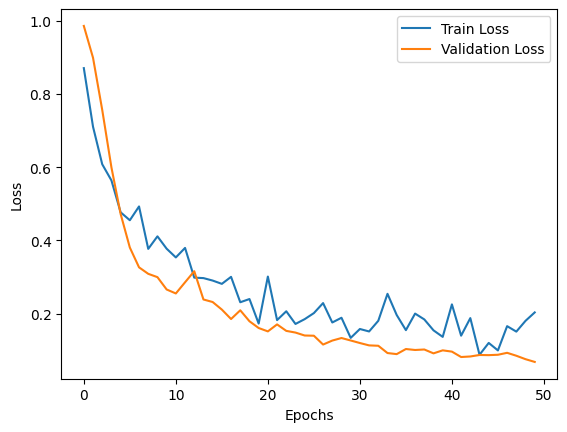

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [17]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Graficar las pérdidas
plot_losses(train_losses, val_losses)

# Evaluar el modelo en conjunto de validación
evaluate_model(model, val_loader)
